In [24]:
'''Required Libraries'''
import numpy as np
import pennylane as qml
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy
import sympy
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch_geometric.nn import GCNConv

import warnings
warnings.filterwarnings("ignore")
np.random.seed(int(np.random.rand(1)[0]*1000))

In [2]:
'''Helper Functions'''

def ground_state(H):
    ''' H : matrix form of Hamiltonian (array)
        outputs: [ground state, ground state energy] of H'''
    H = scipy.sparse.csr_matrix(np.array(H))
    eigvals, eigvecs = scipy.sparse.linalg.eigs(H)
    return eigvecs[:, np.argmin(eigvals)], np.real(min(eigvals))

def operator(pauli):
    ''' pauli : (string) eg. XXZ 
        outputs: matrix form of the pauli term'''
    ops = {'I':np.array([[1,0],[0,1]]),
           'X':np.array([[0,1],[1,0]]),
           'Y':np.array([[0,-1j],[1j,0]]),
           'Z':np.array([[1,0],[0,-1]])}
    term = ops[pauli[0]]
    for i in range(1,len(pauli)):
        term = np.kron(term,ops[pauli[i]])
    return term

def expectation(O,psi):
    '''O    : observable's matrix (array)
       psi  : Statevector (array)
       outputs : expectation value'''
    return np.matmul(psi,np.matmul(O,psi.conj().T)).round(5)

def partial_trace(rho, keep, dims):
    '''rho : the density matrix of the system
       keep : the subsystems you want to trace out
       dims : dimensions of the all the subsystems
       outputs : partial trace'''
    keep = np.array(keep)
    dims = np.array(dims)
    n = len(dims)
    N = np.prod(dims[keep])

    index1 = [i for i in range(n)]
    index2 = [n+i if i in keep else i for i in range(n)]
    rho = rho.reshape(np.tile(dims,2))
    rho = np.einsum(rho, index1+index2)
    return rho.reshape(N, N)

def entanglement_entropy(sv,n):
    '''sv : statevector of the 1d system
       n : index of the edge where we are considering the partition
       outputs: the entanglement entropy of the system on the left'''
    rho = np.outer(sv.conj().T, sv)
    dims = np.log2(len(sv))
    ndim = [2 for i in range(int(dims))]
    rho = partial_trace(rho, n, ndim)
    return np.real((-1)*(np.trace(rho @ scipy.linalg.logm(rho))))

def renyi_trace(rho,n):
    '''sv : statevector of the 2d system
       n : index of the subsystem whose entropy we aim to calculate
       outputs: partial trace'''
    dims = int(np.log2(len(rho)))
    ndim = [2 for i in range(dims)]
    rho = partial_trace(rho,n,ndim)
    return rho

def renyi_entropy_mat(rho):
    '''sv : statevector of the 2d system
       outputs: the renyi entropy matrix'''
    n = int(np.log2(len(rho)))
    entropi = np.zeros((n,n), dtype=float)
    for i in range(n):
        ent = renyi_trace(rho,i)
        entropi[i,i] = -np.log(np.real(np.trace(np.matmul(ent,ent))))
        for j in range(i+1,n):
            ent = renyi_trace(rho,[i,j])
            entropi[i,j] = entropi[j,i] = -np.log(np.real(np.trace(np.matmul(ent,ent))))
    return entropi

def graph_data(J):
    '''J : coupling matrix for 2d systems
       outputs : data preprocessed for GCN'''
    cmax = np.max(J, axis=(0,1)).reshape((1,1))
    cmin = np.min(J, axis=(0,1)).reshape((1,1))
    J = (J - cmin) / (cmax - cmin)
    wts = []
    edges = [[],[]]
    for i in range(len(J)):
        for j in range(i):
            if adj_mat[j][i]!=0:
                edges[0].append(j)
                edges[0].append(i)
                edges[1].append(i)
                edges[1].append(j)
                wts.append(J[j][i])
                wts.append(J[j][i])
    wts = torch.tensor(wts).float()
    edges = torch.tensor(edges).float()
    return GraphData(x=torch.eye(len(J)).float(),edge_index=edges,edge_weights=wts)

In [3]:
'''Saving and Loading data'''
import pickle
def dump(name,var):
    with open(name+'.pkl', 'wb') as file:
        pickle.dump(var, file)

def load(name):
    with open(name+'.pkl', 'rb') as file:
        return pickle.load(file)

In [4]:
'''Classical Shadow Functions'''
# outputs a list of snapshot states
def classical_shadow(circuit,params,num_shadows,num_qubits):
    '''circuit     : Any Quantum Circuit containing the State
       params      : List of Parameters needed in the Quantum Circuit
       num_shadows : Number of snapshots to be extracted
       num_qubits  : Number of qubits used in the Circuit
       outputs : classical shadows, measurement indexes'''
    unitary = {0:qml.PauliX, 1:qml.PauliY, 2:qml.PauliZ}
    mat = np.random.randint(0,3,size=(num_shadows,num_qubits))
    exp = []
    for i in range(num_shadows):
        k = []
        for j in range(num_qubits):
            k.append(unitary[int(mat[i,j])](int(j)))
        exp.append(circuit(params,k).numpy())
    
    def snapshot_state(string,index):
            unitary = {0 : {-1 : (1/np.sqrt(2))*np.array([[1],[-1]]), 1 : (1/np.sqrt(2))*np.array([[1],[1]])},
                       1 : {-1 : (1/np.sqrt(2))*np.array([[1],[-1j]]), 1 : (1/np.sqrt(2))*np.array([[1],[1j]])},
                       2 : {-1 : np.array([[0],[1]]), 1 : np.array([[1],[0]])}}
            eye = np.array([[1,0],[0,1]])
            state = []
            for i in range(len(string)):
                term = unitary[index[i]][string[i]]
                state.append(3*np.matmul(term,term.conj().T) - eye)
    
            ans = state[0]
            for j in range(1,len(string)):
                ans = np.kron(ans,state[j])
            return ans
    
    snaps = []
    for i in range(num_shadows):
        snaps.append(snapshot_state(exp[i],mat[i]))
        
    exp = np.array(exp)
    exp[exp==-1] = 0
    values = 2*mat + exp
    return snaps, values

# reconstructs a state density matrix of input shadow(list of snapshots) 
def reconstructed_state(shadow):
    '''shadow : List of classical shadows of the state to be reconstructed
       outputs : the reconstructed state'''
    num_snapshots = len(shadow)
    num_qubits = int(np.log2(len(shadow[0])))
    state = np.zeros((2**num_qubits, 2**num_qubits),dtype=complex)
    for i in range(num_snapshots):
        state += shadow[i]
    return state/num_snapshots

# provides an approximate observable expectation value
def obs_prediction(obs,shadow,K):
    '''obs    : Observable to be predicted (Matrix form)
       shadow : List of shadows
       K      : number of partitions
       outputs : the predicted observable expectation value'''
    N = len(shadow)
    qubits = int(np.log2(len(shadow[0])))
    num = int(np.floor(N/K))
    
    k = 0
    rho = []
    for i in range(K):
        term = np.zeros((2**qubits,2**qubits),dtype=complex)
        for j in range(num):
            term += shadow[k]
            k+=1
        rho.append((1/num)*term)
        
    exp = []
    for i in rho:
        exp.append(np.trace(np.matmul(obs,i)))
    return np.real(np.median(exp))

# classical shadow(snapshots) of ground state of input Hamiltonian
def groundstate_shadow(num_snaps,H):
    '''num_snaps : number of snapshots (more snapshots -> high computational cost along with high accuracy)
       H : Matrix form of Hamiltonian (array)'''
    state,v = ground_state(H)
    num_qubits = int(np.log2(len(H)))
    
    dev = qml.device("default.qubit", wires=num_qubits,shots=1)
    @qml.qnode(dev)
    def circuit(state,obs):
        state = state/np.linalg.norm(state)
        qml.QubitStateVector(state, wires=range(num_qubits))
        return [qml.expval(o) for o in obs]
    
    shadow, values = classical_shadow(circuit,state,num_snaps,num_qubits)
    return shadow, values

In [5]:
'''The Heisenberg Spin Model'''
def Heisenberg_Model(J):
    ''' outputs the matrix corresponding to the Hamiltonian of the Heisenberg spin model with input coupling matrix J'''
    N = len(J)
    edges = []
    for i in range(N):
        for j in range(i):
            edges.append([j,i])
    
    iden = 'I'
    for i in range(N-2):
        iden+='I'
    
    H_terms = []
    H = np.zeros((2**N,2**N),dtype=complex)
    for term in edges:
        for m in ['X','Y','Z']:
            K = iden[:term[0]]+m+iden[term[0]+1:term[1]]+m+iden[term[1]:]
            H = H + J[term[0]][term[1]]*operator(K)
    return H

def random_couplings(row,col):
    '''outputs a random coupling matrix corresponding to input model configuration'''
    edges = []
    k = np.array([[i+j*col for i in range(col)] for j in range(row)])
    for j in range(row):
        for i in range(col-1):
            edges.append((k[j][i],k[j][i+1]))

    for j in range(col):
        for i in range(row-1):
            edges.append((k[i][j],k[i+1][j]))

    coeffs = []
    mat = np.zeros((row*col,row*col))
    for i,j in edges:
        k = np.random.rand(1)[0]*2
        mat[i,j] = k
        mat[j,i] = k
        coeffs.append(k)
    return mat, coeffs

def given_couplings(row,col,coeffs):
    '''forms the coupling matrix for the provided coefficients'''
    edges = []
    k = np.array([[i+j*col for i in range(col)] for j in range(row)])
    for j in range(row):
        for i in range(col-1):
            edges.append((k[j][i],k[j][i+1]))

    for j in range(col):
        for i in range(row-1):
            edges.append((k[i][j],k[i+1][j]))
    
    m = 0
    mat = np.zeros((row*col,row*col))
    for i,j in edges:
        k = coeffs[m]
        m+=1
        mat[i,j] = k
        mat[j,i] = k 
    return mat

def correlationfn(i,j,N):
        C=np.zeros((2**N,2**N),dtype=complex)
        term = ['I','I','I']
        for k in range(N):
            if (i==k+1 or j==k+1) and i!=j: 
                term[0]+='X'
                term[1]+='Y'
                term[2]+='Z'
            else: 
                term[0]+='I'
                term[1]+='I'
                term[2]+='I'
        term = [term[0][1:],term[1][1:],term[2][1:]]
        for i in term: C += operator(i)
        return (1/3)*C

def corr_mat(H):
    ''' this function gives the correlation matrix calculated on the ground statevector obtained using Exact Diagonalization'''
    num_qubits = int(np.log2(len(H)))
    matrix = np.zeros((num_qubits,num_qubits), dtype=complex)
    state,value = ground_state(H)
    for i in range(num_qubits):
        for j in range(num_qubits):
            op = correlationfn(i+1,j+1,num_qubits)
            matrix[i,j] = expectation(op,state)
    return np.real(matrix)

def shadow_corr(num_shots,H):
    '''The approximate correlation matrix constructed using the prediction algortihm of classical shadows'''
    num_qubits = int(np.log2(len(H)))
    matrix = np.zeros((num_qubits,num_qubits), dtype=complex)
    shad, values = groundstate_shadow(num_shots,H)

    for i in range(num_qubits):
        for j in range(num_qubits):
            op = correlationfn(i+1,j+1,num_qubits)
            matrix[i,j] = obs_prediction(op,shad,5)
    return np.real(matrix), shad

In [6]:
num_snaps = 1000
coupling, coeffs  = random_couplings(2,2)
print('Coupling Matrix:\n', coupling.round(2))

H = Heisenberg_Model(coupling)
g_state, g_energy = ground_state(H)
print('\nGround State Energy:',g_energy)

rho = np.outer(g_state, g_state.conj().T)
entropy = renyi_entropy_mat(rho)
print('\nRenyi Entropy Matrix:\n', entropy.round(2))

correlations = np.real(corr_mat(H))
print('\nThe correlation matrix obtained from exact ground state\n',correlations.round(2))

shadow_correlations, shadow = shadow_corr(num_snaps,H)
print('\nThe correlation matrix directly predicted by classical shadows\n', shadow_correlations.round(2))

g_shadow, g_values = groundstate_shadow(num_snaps,H)
shadow_predicted_energy = obs_prediction(H,g_shadow,5)
reconstructed = reconstructed_state(g_shadow)
shadow_energy = np.real(np.trace(np.matmul(H,reconstructed)))
print('\nShadow Prediction of GSE:',shadow_predicted_energy)
print('\nShadow Computation of GSE:',shadow_energy)

Coupling Matrix:
 [[0.   1.3  1.76 0.  ]
 [1.3  0.   0.   0.36]
 [1.76 0.   0.   1.01]
 [0.   0.36 1.01 0.  ]]

Ground State Energy: -8.87737611573505

Renyi Entropy Matrix:
 [[0.69 0.47 0.61 1.1 ]
 [0.47 0.69 1.1  0.61]
 [0.61 1.1  0.69 0.47]
 [1.1  0.61 0.47 0.69]]

The correlation matrix obtained from exact ground state
 [[ 1.   -0.71 -0.62  0.33]
 [-0.71  1.    0.33 -0.62]
 [-0.62  0.33  1.   -0.71]
 [ 0.33 -0.62 -0.71  1.  ]]

The correlation matrix directly predicted by classical shadows
 [[ 1.   -0.72 -0.67  0.33]
 [-0.72  1.    0.39 -0.61]
 [-0.67  0.39  1.   -0.72]
 [ 0.33 -0.61 -0.72  1.  ]]

Shadow Prediction of GSE: -8.182674002394394

Shadow Computation of GSE: -8.415405902907063


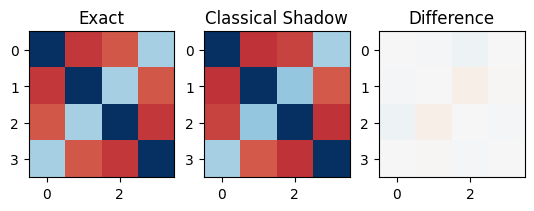

In [7]:
'''Visual Plots for Comparison'''
f, axarr = plt.subplots(1,3)

axarr[0].set_title('Exact')
axarr[0].imshow(correlations, cmap=plt.get_cmap("RdBu"), vmin = -1,vmax = 1)

axarr[1].set_title('Classical Shadow')
axarr[1].imshow(shadow_correlations, cmap=plt.get_cmap("RdBu"), vmin = -1,vmax = 1)

axarr[2].set_title('Difference')
axarr[2].imshow(correlations-shadow_correlations, cmap=plt.get_cmap("RdBu"), vmin = -1,vmax = 1)

In [23]:
def generate_dataset(num_data, model_shape, num_snaps):
    
    params, shadows, states, measurements = [], [], [], []
    
    for i in range(num_data):
        J, terms = random_couplings(model_shape[0], model_shape[1])
        H = Heisenberg_Model(J)
        gshadow, val = groundstate_shadow(num_snaps,H)
        state = reconstructed_state(gshadow)
        shadows.append(gshadow)
        measurements.append(val)
        params.append(terms)
        states.append(state)
        
    return np.array(params), np.array(shadows), np.array(states), np.array(measurements)

params, shadows, states, measurements  = generate_dataset(num_data=100, model_shape=(2,2), num_snaps=500)

In [27]:
len(measurements[0][0])

4

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Compute the positional encoding once in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].requires_grad_(False)
        return self.dropout(x)

class Embedding(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.d_model)
        return x

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.linear2(x)
        return x
    

def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attention_weights = nn.functional.softmax(scores, dim=-1)

    if dropout is not None:
        attention_weights = dropout(attention_weights)

    context = torch.matmul(attention_weights, value)
    return context, attention_weights


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.dropout = nn.Dropout(p=dropout)

        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_o = nn.Linear(d_model, d_model)
        self.attn = None

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)

        n_batches = query.size(0)
        query, key, value = [
            lin(x).view(n_batches, -1, self.n_heads, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(n_batches, -1, self.n_heads * self.d_k)

        del query
        del key
        del value
        return self.linears[-1](x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True, unbiased=False)
        return ((x - mean) / (std + self.eps)) * self.gamma + self.beta

class SublayerConnection(nn.Module):
    def __init__(self, d_model, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
    
import torch.nn as nn

class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn: MultiHeadAttention, feed_forward: PositionWiseFeedForward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer1 = SublayerConnection(size, dropout)
        self.sublayer2 = SublayerConnection(size, dropout)
        self.sublayer3 = SublayerConnection(size, dropout)

    def forward(self, x, tgt_mask):
        x = self.sublayer1(x, lambda x: self.self_attn(
            query=x, key=x, value=x, mask=tgt_mask
        ))
        x = self.sublayer2(x, lambda x: self.self_attn(
            query=x, key=x, value=x, mask=tgt_mask
        ))
        return self.sublayer3(x, self.feed_forward)
    
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

class Decoder(nn.Module):
    def __init__(self, layer: DecoderLayer, n_layers: int):
        super(Decoder, self).__init__()
        self.layers = []
        for i in range(len(n_layers)):
            self.layers.append(layer)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, tgt_mask=mask)
        return self.norm(x)

In [11]:
class KLDLoss(nn.Module):
    def __init__(self, padding):
        super(KLDLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding = padding
        
    def forward(self, x, target):
        onehot = torch.zeros_like(x)
        onehot.scatter_(1, target.unsqueeze(1), 1.0)
        if self.padding >= 0:
            onehot[:, self.padding] = 0
        mask = torch.nonzero(target.data == self.padding)
        if mask.dim() > 0:
            onehot.index_fill_(0, mask.squeeze(), 0.0)
        loss = self.criterion(x, target_onehot)
        return loss

criterion = KLDLoss(padding=-1)
steps = 2000
optimizer = torch.optim.AdamW(transformer.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps, eta_min=1e-7)

NameError: name 'transformer' is not defined

In [ ]:
class TgtBatch:
    def __init__(self, tgt, pad):
        self.tgt = tgt[:, :-1]
        self.tgt_y = tgt[:, 1:]
        self.tgt_mask = make_std_mask(self.tgt, pad)
        self.ntokens = (self.tgt_y != pad).data.sum()
        
def subsequent_mask(size):
    attn_shape = (1, size, size)
    mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return mask == 0


def make_std_mask(tgt, pad):
    tgt_mask = (tgt != pad).unsqueeze(-2) 
    tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
    return tgt_mask


def batch_iterator(data, graphs_list, iterations, batch_size, shuffle=True):
    for step in range(1, iterations + 1):
        indices = rng.choice(len(data), batch_size, replace=True)
        tgt_batch = TgtBatch(data[indices], pad=-1)
        graphs_batch = GraphBatch.from_data_list(data_list=[graphs_list[i] for i in indices])
        yield tgt_batch, graphs_batch

In [ ]:
class GraphTransformer(nn.Module):
    def __init__(self, encoder, decoder, embed, generator, num_outcomes, dim_model, pad_token, start_token, end_token, tokenshift):
        super(GraphTransformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.generator = generator
        self.n_outcomes = n_outcomes
        self.d_model = d_model

        self.pad_token = pad_token
        self.start_token = start_token
        self.end_token = end_token
        self.token_shift = token_shift

    def forward(self, tgt, tgt_mask, coupling_graph):
        """ process masked target sequences """
        tgt_embed = self.tgt_embed(tgt)
        graph_embed = self.encoder(coupling_graph)
        graph_embed = graph_embed[:, :tgt_embed.shape[1], :]
        tgt_embed = tgt_embed + graph_embed

        return graph_embed, self.decoder(tgt_embed, tgt_mask)

    def sample_batch(self, batch_size, coupling_graph, qubits):
        num_valid_samples = 0
        valid_samples = None

        num_restarts = 0

        while num_valid_samples < batch_size:
            tgt = torch.ones(batch_size - num_valid_samples, 1).type(
                LongTensor) * self.start_token

            for i in range(qubits):
                mask = make_std_mask(tgt, pad=self.pad_token)

                _, out = self.forward(tgt, mask, coupling_graph)
                log_probs = self.generator(out[:, -1])
                probs = torch.exp(log_probs).detach()
                probs = probs / probs.sum(axis=-1).reshape(
                    batch_size - num_valid_samples, 1)

                next_outcomes = torch.multinomial(probs, 1, replacement=True)

                tgt = torch.cat([tgt, next_outcomes], dim=1)
            tgt = tgt.cpu().numpy()
            tgt = tgt[:, 1:] - self.token_shift
            tgt = tgt[np.all(tgt >= 0, axis=1), :]

            if valid_samples is None:
                valid_samples = tgt
            else:
                valid_samples = np.concatenate([valid_samples, tgt], axis=0)

            num_valid_samples = valid_samples.shape[0]

            num_restarts += 1
            if num_restarts > 10:
                print(
                    f'sampling timed out: got {num_valid_samples} instead of {batch_size}')
                break

        return valid_samples

    def sample(self, samples, coupling_graph, qubits, batch_size=1000,
               print_progress=True) -> np.ndarray:
        batch_sizes = [batch_size] * int(samples // batch_size)
        batch_sizes = batch_sizes + (
            [] if samples % batch_size == 0 else [samples % batch_size])

        if print_progress:
            pbar = tqdm(batch_sizes,
                        postfix=f'generating {samples} samples from model...')
        else:
            pbar = batch_sizes

        batch_samples = [self.sample_batch(bs, coupling_graph, qubits) for bs in pbar]
        samples = np.concatenate(batch_samples, axis=0)
        return samples

In [29]:
class GCNEncoder(nn.Module):
    def __init__(self, num_qubits, input_dim, gcn_dim, transformer_dim, num_layers):
        super(GCNEncoder, self).__init__()
        channel = [input_dim]
        channel = channel + [2 ** (num_layers - 1 - i) * gcn_dim for i in range(num_layers - 1)]
        channel = channel + [gcn_dim]
        
        self.transformer = transformer_dim
        self.channels = gcn_dim
        self.nodes = num_qubits
        
        self.gcn = []
        for i in range(len(channel)-1):
            self.gcn.append(GCNConv(channel[i],channel[i+1]))
        
        self.linear = nn.Linear(num_qubits*gcn_dim, transformer_dim)
        self.layers = nn.Sequential(*self.gcn, self.linear)

    def forward(self, data):
        x, index, weight = data.x, data.edge_index, data.edge_weight

        for layer in self.layers[:-1]:
            x = layer(x, index, weight).relu()

        embed = x.view(-1, self.channels * self.nodes)
        proj = self.layers[-1](embed)
        proj = proj.view(data.num_graphs, -1, self.transformer)
        return proj

num_qubits = len(coupling)
input_dim = len(measurements[0][0])
gcn_dim = 16
transformer_dim = 128
num_layers = 3
encoder = GCNEncoder(num_qubits, input_dim, gcn_dim, transformer_dim, num_layers)

In [ ]:
num_heads = 4
num_layers = 4
dim_model = 128
dim_ff = 4*128
num_outcomes = 6
dropout = 0.0
pad_token = -1
start_token = 0
end_token = -1
token_shift = 1

attention = MultiHeadAttention(num_heads, dim_model, dropout)
feedforward = PositionwiseFeedForward(dim_model, dim_ff, dropout)
position = PositionalEncoding(dim_model, dropout)
size = num_outcomes + token_shift

generator = Generator(dim_model, size)
decoder = Decoder(DecoderLayer(dim_model, deepcopy(attention), deepcopy(feedforward), dropout), n_layers = num_layers)
embed = nn.Sequential(Embedding(dim_model, size), deepcopy(position))

model = GraphTransformer(encoder=encoder, 
                         pad_token = pad_token, 
                         start_token = start_token, 
                         end_token = end_token,
                         token_shift = token_shift, 
                         dim_model=dim_model, 
                         num_outcomes = num_outcomes,
                         generator = generator,
                         decoder = Decoder(DecoderLayer(dim_model, deepcopy(attention), deepcopy(feedforward), dropout), n_layers = num_layers),
                         embed = nn.Sequential(Embedding(dim_model, size), deepcopy(position)))

for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)